In [1]:
# Installing necessary packages
# !pip install keras-tuner

In [2]:
# !pip install xgboost


In [1]:


# Importing necessary libraries
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model, save_model

import tensorflow as tf


/var/folders/1g/bksky7bd2wb927qzgc2fqjhc0000gn/T/ipykernel_2840/4118812801.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the data
waveforms = pd.read_csv('~/data/practicum-data/ABRpresto data/processed_data/updated_processed_waveforms.csv')
thresholds = pd.read_csv('~/data/practicum-data/ABRpresto data/ABRpresto data/Manual Thresholds.csv')

waveforms = waveforms.rename(columns={"mouse_id": "id", "time_point": "timepoint"})

# Perform the left join on specified columns
merged_df = pd.merge( 
    thresholds, 
    waveforms,
    how='right', 
    on=['id', 'timepoint', 'ear', 'frequency']
)


In [4]:
merged_df.head(5)

,id,timepoint,ear,frequency,min_level,max_level,manual threshold,level,1,2,...,234,235,236,237,238,239,240,241,242,243
0,155,1,left,4000.0,15.0,105.0,70.0,15.0,-1.221967e-07,-1.025707e-07,...,1.701512e-07,1.761305e-07,1.915403e-07,1.983019e-07,1.896948e-07,1.718040e-07,1.550264e-07,1.347835e-07,1.044327e-07,6.399865e-08
1,155,1,left,4000.0,15.0,105.0,70.0,20.0,1.649993e-07,1.665737e-07,...,-4.024921e-08,-6.394044e-08,-6.811376e-08,-5.390779e-08,-3.666727e-08,-1.600967e-08,1.787785e-09,-2.048963e-09,-2.039571e-08,-3.387016e-08
2,155,1,left,4000.0,15.0,105.0,70.0,25.0,1.649815e-07,1.497355e-07,...,3.274994e-09,-5.608839e-08,-1.014989e-07,-8.578703e-08,-6.040631e-08,-7.962887e-08,-1.092591e-07,-9.873568e-08,-5.931209e-08,-2.430632e-08
3,155,1,left,4000.0,15.0,105.0,70.0,30.0,1.143589e-07,1.241433e-07,...,1.205242e-08,-3.354167e-09,-4.702899e-09,-3.079469e-10,8.391719e-10,3.972793e-09,1.610461e-08,3.059214e-08,2.769940e-08,-1.027032e-08
4,155,1,left,4000.0,15.0,105.0,70.0,35.0,1.148238e-07,1.387666e-07,...,-1.771918e-07,-1.909677e-07,-2.315494e-07,-2.652825e-07,-2.680147e-07,-2.507890e-07,-2.371962e-07,-2.259854e-07,-1.765978e-07,-6.666764e-08


In [5]:
merged_df['id_freq'] = \
     merged_df['id'].astype(str) \
    + merged_df['frequency'].astype(int).astype(str) \
    + np.where(merged_df['ear'] == 'left', '0', '1') \
    + merged_df['timepoint'].astype(str)

In [6]:
merged_df.head(5)

,id,timepoint,ear,frequency,min_level,max_level,manual threshold,level,1,2,...,235,236,237,238,239,240,241,242,243,id_freq
0,155,1,left,4000.0,15.0,105.0,70.0,15.0,-1.221967e-07,-1.025707e-07,...,1.761305e-07,1.915403e-07,1.983019e-07,1.896948e-07,1.718040e-07,1.550264e-07,1.347835e-07,1.044327e-07,6.399865e-08,155400001
1,155,1,left,4000.0,15.0,105.0,70.0,20.0,1.649993e-07,1.665737e-07,...,-6.394044e-08,-6.811376e-08,-5.390779e-08,-3.666727e-08,-1.600967e-08,1.787785e-09,-2.048963e-09,-2.039571e-08,-3.387016e-08,155400001
2,155,1,left,4000.0,15.0,105.0,70.0,25.0,1.649815e-07,1.497355e-07,...,-5.608839e-08,-1.014989e-07,-8.578703e-08,-6.040631e-08,-7.962887e-08,-1.092591e-07,-9.873568e-08,-5.931209e-08,-2.430632e-08,155400001
3,155,1,left,4000.0,15.0,105.0,70.0,30.0,1.143589e-07,1.241433e-07,...,-3.354167e-09,-4.702899e-09,-3.079469e-10,8.391719e-10,3.972793e-09,1.610461e-08,3.059214e-08,2.769940e-08,-1.027032e-08,155400001
4,155,1,left,4000.0,15.0,105.0,70.0,35.0,1.148238e-07,1.387666e-07,...,-1.909677e-07,-2.315494e-07,-2.652825e-07,-2.680147e-07,-2.507890e-07,-2.371962e-07,-2.259854e-07,-1.765978e-07,-6.666764e-08,155400001


In [7]:
def normalize_group(group):
    # Columns to exclude from scaling
    exclude_cols = ['manual threshold', 'level', 'id']
    
    # Select numeric columns but exclude the specified columns
    data_to_scale = group.select_dtypes(include=['number']).drop(columns=exclude_cols, errors='ignore')
    
    # Flatten the data to scale all values across the group
    flattened_data = data_to_scale.values.flatten().reshape(-1, 1)
    
    # Fit the scaler on the flattened data
    scaler = StandardScaler()
    scaled_flattened_data = scaler.fit_transform(flattened_data).reshape(data_to_scale.shape)
    
    # Reshape back to the original shape and update the group
    group = group.copy()  # Avoid inplace modification
    group[data_to_scale.columns] = scaled_flattened_data
    
    return group

In [8]:
grouped = merged_df \
            .drop(columns=['timepoint', 'ear', 'frequency', 'min_level', 'max_level'])\
            .groupby(['id_freq']) # , 'manual threshold', 'level'

In [9]:
print(grouped.size())

id_freq
01600000      14
03200000      14
0800000       14
1001131300    19
1001131310     9
              ..
994525401      9
99565600      10
99565601       9
99800000      10
99800001       9
Length: 7894, dtype: int64


In [10]:
normalized_merged_df1 = grouped.apply(normalize_group).reset_index(drop=True)

In [11]:
normalized_merged_df1.head(20)

,id,manual threshold,level,1,2,3,4,5,6,7,...,235,236,237,238,239,240,241,242,243,id_freq
0,0,40.0,15.0,0.600951,0.524525,0.468409,0.412414,0.342675,0.255969,0.193010,...,0.076028,0.020515,-0.011562,-0.045580,-0.071435,-0.078972,-0.081087,-0.054537,0.023515,01600000
1,0,40.0,20.0,-0.622469,-0.489024,-0.416342,-0.407255,-0.404202,-0.388576,-0.395910,...,0.230679,0.179337,0.108626,0.031035,-0.042411,-0.092526,-0.081257,-0.010586,0.083955,01600000
2,0,40.0,25.0,0.739883,0.770380,0.758815,0.696910,0.569778,0.394513,0.201721,...,0.082675,0.086412,0.102626,0.123194,0.136408,0.123401,0.082134,0.041566,0.024323,01600000
3,0,40.0,30.0,-0.422527,-0.495352,-0.587536,-0.719317,-0.837653,-0.890947,-0.922574,...,-0.356476,-0.364862,-0.345238,-0.329188,-0.329386,-0.299165,-0.235088,-0.189407,-0.156326,01600000
4,0,40.0,35.0,-0.229618,-0.220355,-0.231026,-0.223591,-0.202366,-0.167653,-0.113815,...,-0.356816,-0.468449,-0.533057,-0.539197,-0.523349,-0.474118,-0.374838,-0.256068,-0.143360,01600000
5,0,40.0,40.0,0.133701,0.039611,-0.056099,-0.189979,-0.354252,-0.499115,-0.573046,...,1.043488,1.034542,0.992562,0.929210,0.834517,0.724999,0.619404,0.509761,0.408949,01600000
6,0,40.0,45.0,-0.226593,-0.059363,0.095105,0.225498,0.319434,0.369827,0.372969,...,0.018488,0.041486,0.044556,0.047463,0.041988,0.027540,0.018783,0.011206,0.002336,01600000
7,0,40.0,50.0,0.002557,-0.016748,-0.035981,-0.036104,-0.031863,-0.038601,-0.038013,...,-0.483190,-0.471073,-0.474815,-0.475433,-0.449104,-0.407423,-0.357606,-0.281834,-0.184225,01600000
8,0,40.0,55.0,1.627191,1.553463,1.426910,1.287616,1.141655,0.999999,0.864398,...,-0.205134,-0.214372,-0.190938,-0.157250,-0.125628,-0.124821,-0.146080,-0.140068,-0.101470,01600000
9,0,40.0,60.0,-0.159004,-0.129899,-0.052664,0.048445,0.129325,0.181046,0.217673,...,-0.944802,-0.919451,-0.865639,-0.788757,-0.695397,-0.598832,-0.513479,-0.442614,-0.363817,01600000


In [12]:
# mask = ~np.isinf(normalized_merged_df1["manual threshold"])

# # Apply the mask to keep only the good values
# normalized_merged_df = normalized_merged_df1[mask]
normalized_merged_df = normalized_merged_df1

In [22]:
y_train = np.array(normalized_merged_df['manual threshold'])
X_train = normalized_merged_df.drop(columns=['manual threshold', 'level', 'id_freq', 'id'])

X_train_cnn = np.expand_dims(X_train.values, axis=2)

In [23]:
normalized_merged_df.iloc[0, 2:245]

level        15.0
1        0.600951
2        0.524525
3        0.468409
4        0.412414
           ...   
238      -0.04558
239     -0.071435
240     -0.078972
241     -0.081087
242     -0.054537
Name: 0, Length: 243, dtype: object

In [24]:
X_train_cnn.shape

(122874, 243, 1)

In [25]:
model = load_model('/Users/peeyushpatel/Downloads/abr_cnn_aug_norm_std.keras')

2025-02-24 13:27:17.954888: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-24 13:27:17.955092: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-24 13:27:17.955110: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-24 13:27:17.955346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-24 13:27:17.955372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
y_train.shape

(122874,)

In [27]:
data = merged_df \
        .drop(columns=['id', 'timepoint', 'ear', 'frequency', 'min_level', 'max_level'])

In [28]:
data['Hearing'] = np.where(data['manual threshold'] <= data['level'], 1, 0)

In [29]:
# data = data[mask]

In [30]:
normalized_merged_df['Hearing'] = np.where(normalized_merged_df['manual threshold'] <= normalized_merged_df['level'], 1, 0)

In [31]:
normalized_merged_df.shape

(122874, 248)

In [13]:
from scipy.interpolate import CubicSpline

In [14]:
def interpolate_and_smooth(final, target_length=244):
    if len(final) > target_length:
        new_points = np.linspace(0, len(final), target_length + 2)
        interpolated_values = np.interp(new_points, np.arange(len(final)), final)
        final = np.array(interpolated_values[:target_length], dtype=float)
    elif len(final) < target_length:
        original_indices = np.arange(len(final))
        target_indices = np.linspace(0, len(final) - 1, target_length)
        cs = CubicSpline(original_indices, final)
        final = cs(target_indices)
    return final

In [51]:
data.head(5)

,manual threshold,level,1,2,3,4,5,6,7,8,...,236,237,238,239,240,241,242,243,id_freq,Hearing
0,70.0,15.0,-1.221967e-07,-1.025707e-07,-8.285677e-08,-6.858700e-08,-5.585164e-08,-4.877251e-08,-4.145288e-08,-1.979165e-08,...,1.915403e-07,1.983019e-07,1.896948e-07,1.718040e-07,1.550264e-07,1.347835e-07,1.044327e-07,6.399865e-08,155400001,0
1,70.0,20.0,1.649993e-07,1.665737e-07,1.763594e-07,1.808912e-07,1.688485e-07,1.427747e-07,1.295444e-07,1.392978e-07,...,-6.811376e-08,-5.390779e-08,-3.666727e-08,-1.600967e-08,1.787785e-09,-2.048963e-09,-2.039571e-08,-3.387016e-08,155400001,0
2,70.0,25.0,1.649815e-07,1.497355e-07,1.052809e-07,6.572055e-08,6.237535e-08,7.468753e-08,7.036229e-08,6.078730e-08,...,-1.014989e-07,-8.578703e-08,-6.040631e-08,-7.962887e-08,-1.092591e-07,-9.873568e-08,-5.931209e-08,-2.430632e-08,155400001,0
3,70.0,30.0,1.143589e-07,1.241433e-07,8.455086e-08,1.829748e-08,-8.358678e-09,1.307874e-08,2.212239e-08,-4.218523e-09,...,-4.702899e-09,-3.079469e-10,8.391719e-10,3.972793e-09,1.610461e-08,3.059214e-08,2.769940e-08,-1.027032e-08,155400001,0
4,70.0,35.0,1.148238e-07,1.387666e-07,1.488358e-07,1.542010e-07,1.621005e-07,1.495204e-07,1.039636e-07,6.408325e-08,...,-2.315494e-07,-2.652825e-07,-2.680147e-07,-2.507890e-07,-2.371962e-07,-2.259854e-07,-1.765978e-07,-6.666764e-08,155400001,0


In [52]:
normalized_merged_df.head(10)

,id,manual threshold,level,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,id_freq,Hearing
0,0,40.0,15.0,0.600951,0.524525,0.468409,0.412414,0.342675,0.255969,0.193010,...,0.020515,-0.011562,-0.045580,-0.071435,-0.078972,-0.081087,-0.054537,0.023515,01600000,0
1,0,40.0,20.0,-0.622469,-0.489024,-0.416342,-0.407255,-0.404202,-0.388576,-0.395910,...,0.179337,0.108626,0.031035,-0.042411,-0.092526,-0.081257,-0.010586,0.083955,01600000,0
2,0,40.0,25.0,0.739883,0.770380,0.758815,0.696910,0.569778,0.394513,0.201721,...,0.086412,0.102626,0.123194,0.136408,0.123401,0.082134,0.041566,0.024323,01600000,0
3,0,40.0,30.0,-0.422527,-0.495352,-0.587536,-0.719317,-0.837653,-0.890947,-0.922574,...,-0.364862,-0.345238,-0.329188,-0.329386,-0.299165,-0.235088,-0.189407,-0.156326,01600000,0
4,0,40.0,35.0,-0.229618,-0.220355,-0.231026,-0.223591,-0.202366,-0.167653,-0.113815,...,-0.468449,-0.533057,-0.539197,-0.523349,-0.474118,-0.374838,-0.256068,-0.143360,01600000,0
5,0,40.0,40.0,0.133701,0.039611,-0.056099,-0.189979,-0.354252,-0.499115,-0.573046,...,1.034542,0.992562,0.929210,0.834517,0.724999,0.619404,0.509761,0.408949,01600000,1
6,0,40.0,45.0,-0.226593,-0.059363,0.095105,0.225498,0.319434,0.369827,0.372969,...,0.041486,0.044556,0.047463,0.041988,0.027540,0.018783,0.011206,0.002336,01600000,1
7,0,40.0,50.0,0.002557,-0.016748,-0.035981,-0.036104,-0.031863,-0.038601,-0.038013,...,-0.471073,-0.474815,-0.475433,-0.449104,-0.407423,-0.357606,-0.281834,-0.184225,01600000,1
8,0,40.0,55.0,1.627191,1.553463,1.426910,1.287616,1.141655,0.999999,0.864398,...,-0.214372,-0.190938,-0.157250,-0.125628,-0.124821,-0.146080,-0.140068,-0.101470,01600000,1
9,0,40.0,60.0,-0.159004,-0.129899,-0.052664,0.048445,0.129325,0.181046,0.217673,...,-0.919451,-0.865639,-0.788757,-0.695397,-0.598832,-0.513479,-0.442614,-0.363817,01600000,1


## Normalized Data

In [53]:
# Select features and labels using iloc
X = normalized_merged_df.iloc[:, 3:246].values  # Select columns 2 to 244 (features)
y = normalized_merged_df.iloc[:, -1].values      # Select column 0 (labels)

# Apply interpolation and smoothing to each row in X
X_interpolated = np.array([interpolate_and_smooth(x_row) for x_row in X])

# Ensure the shape is correct after interpolation
print(X_interpolated.shape) 


(122874, 244)


In [54]:
y_pred = (model.predict(X_interpolated) > 0.5).astype(int)

   1/3840 ━━━━━━━━━━━━━━━━━━━━ 18:28 289ms/step

2025-02-24 12:18:05.983445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [55]:
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


In [56]:
def calculate_thresholds(test_data, logic):
    thresholds = []

    for uid, group in test_data.groupby(['id_freq']):
        group = group.sort_values('level', ascending=(logic in ['Bottom-Up', 'Robust Bottom-Up']))
        ground_truth_threshold = group[group['Hearing'] == 1]['level'].min()
        
        lowest_db = None
        previous_prediction = None
        predicted_threshold = None

        for i, (p, d) in enumerate(zip(group['prediction'], group['level'])):
            if p == 0:
                lowest_db = d
                previous_prediction = p
            else:
                if logic in ['Robust Bottom-Up', 'Robust Top-Down'] and previous_prediction == 1:
                    predicted_threshold = lowest_db
                    break  # Break for robust logics
                lowest_db = d
                previous_prediction = p

        if predicted_threshold is None and logic in ['Naive Bottom-Up', 'Naive Top-Down']:
            predicted_threshold = group[group['prediction'] == 1]['level'].min()

        thresholds.append({
            "unique_id": uid,
            'predicted_threshold': predicted_threshold,
            'ground_truth_threshold': ground_truth_threshold,
            'Logic': logic
        })

    return pd.DataFrame(thresholds)


In [57]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def calculate_metrics(y_true, y_pred_prob):
    # Compute TPR, FPR, AUROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auroc = auc(fpr, tpr)

    # Compute Precision-Recall and AUPRC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    auprc = auc(recall, precision)

    return fpr, tpr, auroc, precision, recall, auprc


In [58]:
logics = ['Robust Top-Down', 'Naive Bottom-Up', 'Robust Bottom-Up', 'Naive Top-Down']
results = []

for logic in logics:
    test_data_with_predictions = normalized_merged_df.assign(prediction=y_pred)
    thresholds = calculate_thresholds(test_data_with_predictions, logic)
    thresholds['diff'] = np.abs(thresholds['predicted_threshold'] - thresholds['ground_truth_threshold'])

    within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
    mean_diff = thresholds['diff'].mean()
    std_diff = thresholds['diff'].std() / np.sqrt(len(thresholds))

    results.append({
        'Logic': logic,
        'Within 5 db': within_db_percentages[5],
        'Within 10 db': within_db_percentages[10],
        'Mean Diff': mean_diff,
        'Std Diff': std_diff
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


              Logic  Within 5 db  Within 10 db  Mean Diff  Std Diff
0   Robust Top-Down     7.119331     14.504687  37.366331  0.244250
1   Naive Bottom-Up     8.284773     14.846719  34.480373  0.260192
2  Robust Bottom-Up    17.304282     26.133772  29.270316  0.262502
3    Naive Top-Down     8.284773     14.846719  34.480373  0.260192


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

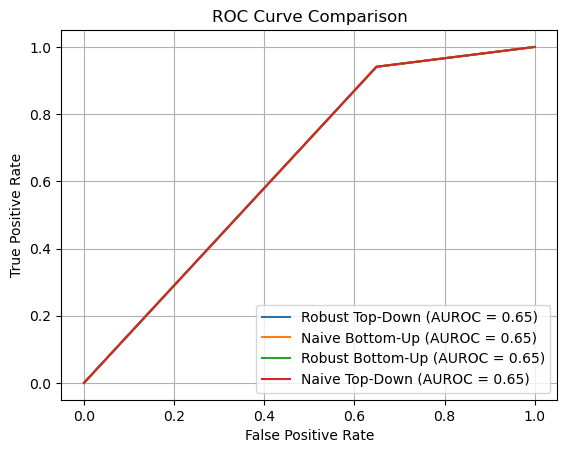

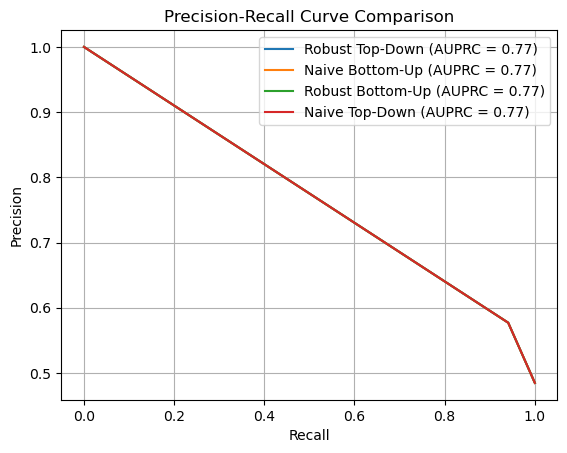

In [59]:
import matplotlib.pyplot as plt

for logic in logics:
    # Generate metrics for plotting
    y_true = test_data_with_predictions['Hearing']
    y_pred_prob = test_data_with_predictions['prediction']  # Use probabilities if available

    fpr, tpr, auroc, precision, recall, auprc = calculate_metrics(y_true, y_pred_prob)

    # Plot ROC Curve
    plt.figure(1)
    plt.plot(fpr, tpr, label=f'{logic} (AUROC = {auroc:.2f})')

    # Plot Precision-Recall Curve
    plt.figure(2)
    plt.plot(recall, precision, label=f'{logic} (AUPRC = {auprc:.2f})')

# Finalize ROC plot
plt.figure(1)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

# Finalize Precision-Recall plot
plt.figure(2)
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()

plt.show()


## Unmodified Data

In [60]:
# Select features and labels using iloc
X = data.iloc[:, 3:246].values  # Select columns 2 to 244 (features)
y = data.iloc[:, -1].values      # Select column 0 (labels)

# Apply interpolation and smoothing to each row in X
X_interpolated = np.array([interpolate_and_smooth(x_row) for x_row in X])

# Ensure the shape is correct after interpolation
print(X_interpolated.shape) 


(122874, 244)


In [ ]:
y_pred = (model.predict(X_interpolated) > 0.5).astype(int)

3840/3840 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [43]:
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.52


In [ ]:
logics = ['Robust Top-Down', 'Naive Bottom-Up', 'Robust Bottom-Up', 'Naive Top-Down']
results = []

for logic in logics:
    test_data_with_predictions = normalized_merged_df.assign(prediction=y_pred)
    thresholds = calculate_thresholds(test_data_with_predictions, logic)
    thresholds['diff'] = np.abs(thresholds['predicted_threshold'] - thresholds['ground_truth_threshold'])

    within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
    mean_diff = thresholds['diff'].mean()
    std_diff = thresholds['diff'].std() / np.sqrt(len(thresholds))

    results.append({
        'Logic': logic,
        'Within 5 db': within_db_percentages[5],
        'Within 10 db': within_db_percentages[10],
        'Mean Diff': mean_diff,
        'Std Diff': std_diff
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


              Logic  Within 5 db  Within 10 db  Mean Diff  Std Diff
0   Robust Top-Down          0.0           0.0        NaN       NaN
1   Naive Bottom-Up          0.0           0.0        NaN       NaN
2  Robust Bottom-Up          0.0           0.0        NaN       NaN
3    Naive Top-Down          0.0           0.0        NaN       NaN


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

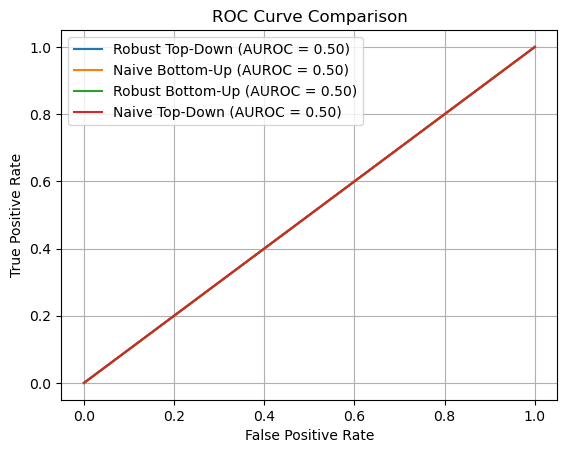

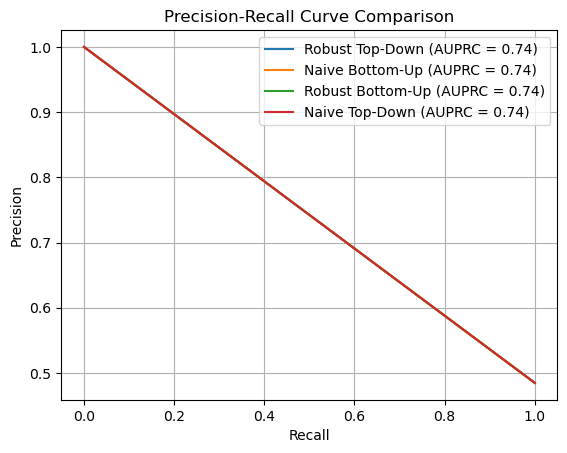

In [ ]:
for logic in logics:
    # Generate metrics for plotting
    y_true = test_data_with_predictions['Hearing']
    y_pred_prob = test_data_with_predictions['prediction']  # Use probabilities if available

    fpr, tpr, auroc, precision, recall, auprc = calculate_metrics(y_true, y_pred_prob)

    # Plot ROC Curve
    plt.figure(1)
    plt.plot(fpr, tpr, label=f'{logic} (AUROC = {auroc:.2f})')

    # Plot Precision-Recall Curve
    plt.figure(2)
    plt.plot(recall, precision, label=f'{logic} (AUPRC = {auprc:.2f})')

# Finalize ROC plot
plt.figure(1)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

# Finalize Precision-Recall plot
plt.figure(2)
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()

plt.show()

## Training the existing model with new data

In [32]:
normalized_merged_df.head(5)

,id,manual threshold,level,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,id_freq,Hearing
0,0,40.0,15.0,0.600951,0.524525,0.468409,0.412414,0.342675,0.255969,0.193010,...,0.020515,-0.011562,-0.045580,-0.071435,-0.078972,-0.081087,-0.054537,0.023515,01600000,0
1,0,40.0,20.0,-0.622469,-0.489024,-0.416342,-0.407255,-0.404202,-0.388576,-0.395910,...,0.179337,0.108626,0.031035,-0.042411,-0.092526,-0.081257,-0.010586,0.083955,01600000,0
2,0,40.0,25.0,0.739883,0.770380,0.758815,0.696910,0.569778,0.394513,0.201721,...,0.086412,0.102626,0.123194,0.136408,0.123401,0.082134,0.041566,0.024323,01600000,0
3,0,40.0,30.0,-0.422527,-0.495352,-0.587536,-0.719317,-0.837653,-0.890947,-0.922574,...,-0.364862,-0.345238,-0.329188,-0.329386,-0.299165,-0.235088,-0.189407,-0.156326,01600000,0
4,0,40.0,35.0,-0.229618,-0.220355,-0.231026,-0.223591,-0.202366,-0.167653,-0.113815,...,-0.468449,-0.533057,-0.539197,-0.523349,-0.474118,-0.374838,-0.256068,-0.143360,01600000,0


In [33]:
len(normalized_merged_df['id_freq'].unique())

7894

In [34]:
from sklearn.model_selection import GroupShuffleSplit

In [35]:
# Define train-test split
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(normalized_merged_df, groups=normalized_merged_df["id"]))

# Create train and test DataFrames
train_df = normalized_merged_df.iloc[train_idx]
test_df = normalized_merged_df.iloc[test_idx]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [37]:
train_df.head(7)

,id,manual threshold,level,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,id_freq,Hearing
0,0,40.0,15.0,0.600951,0.524525,0.468409,0.412414,0.342675,0.255969,0.193010,...,0.020515,-0.011562,-0.045580,-0.071435,-0.078972,-0.081087,-0.054537,0.023515,01600000,0
1,0,40.0,20.0,-0.622469,-0.489024,-0.416342,-0.407255,-0.404202,-0.388576,-0.395910,...,0.179337,0.108626,0.031035,-0.042411,-0.092526,-0.081257,-0.010586,0.083955,01600000,0
2,0,40.0,25.0,0.739883,0.770380,0.758815,0.696910,0.569778,0.394513,0.201721,...,0.086412,0.102626,0.123194,0.136408,0.123401,0.082134,0.041566,0.024323,01600000,0
3,0,40.0,30.0,-0.422527,-0.495352,-0.587536,-0.719317,-0.837653,-0.890947,-0.922574,...,-0.364862,-0.345238,-0.329188,-0.329386,-0.299165,-0.235088,-0.189407,-0.156326,01600000,0
4,0,40.0,35.0,-0.229618,-0.220355,-0.231026,-0.223591,-0.202366,-0.167653,-0.113815,...,-0.468449,-0.533057,-0.539197,-0.523349,-0.474118,-0.374838,-0.256068,-0.143360,01600000,0
5,0,40.0,40.0,0.133701,0.039611,-0.056099,-0.189979,-0.354252,-0.499115,-0.573046,...,1.034542,0.992562,0.929210,0.834517,0.724999,0.619404,0.509761,0.408949,01600000,1
6,0,40.0,45.0,-0.226593,-0.059363,0.095105,0.225498,0.319434,0.369827,0.372969,...,0.041486,0.044556,0.047463,0.041988,0.027540,0.018783,0.011206,0.002336,01600000,1


In [38]:
# Select features and labels using iloc
X_train = np.array([interpolate_and_smooth(x_row) for x_row in train_df.iloc[:, 3:246].values])  # Select columns 2 to 244 (features)
y_train = train_df.iloc[:, -1].values      # Select column 0 (labels)

X_test = np.array([interpolate_and_smooth(x_row) for x_row in test_df.iloc[:, 3:246].values])  # Select columns 2 to 244 (features)
y_test = test_df.iloc[:, -1].values      # Select column 0 (labels)

In [39]:
# Expand dimensions for CNN input
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)


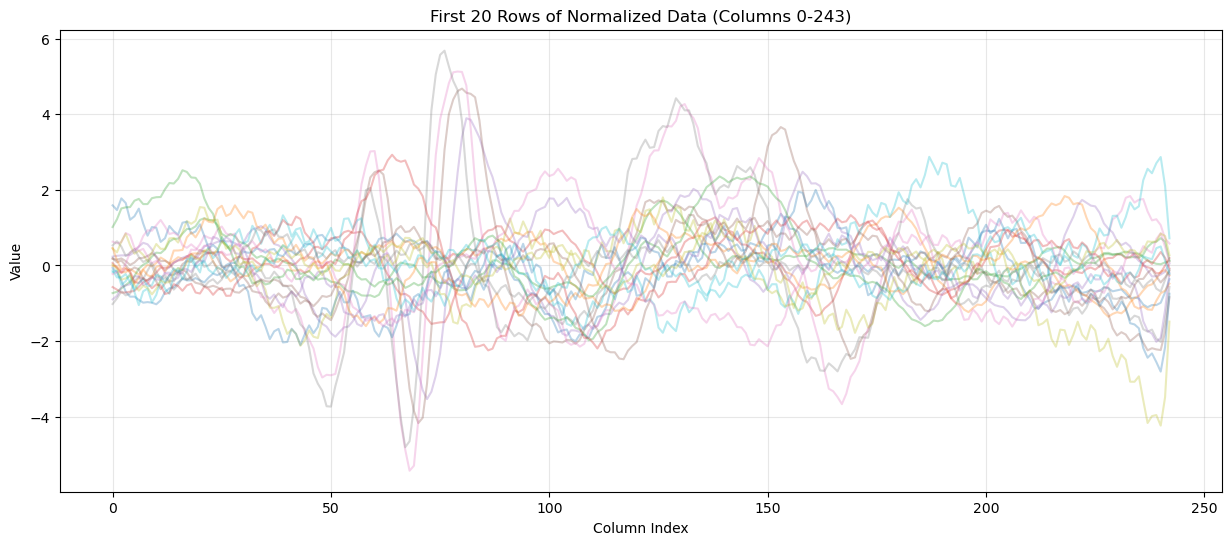

In [42]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))
error=[]

# Plot up to 20 rows
for i, (_, row) in enumerate(train_df.iloc[:, 3:247].iterrows()):  # Use `iloc` for positional slicing
    if i > 220:
        error.append(row.iloc[-1])  # Append the last value of the row to the `error` list
        plt.plot(row.iloc[:-1].values, alpha=0.3)   # Convert the row to a NumPy array for faster plotting
    if i == 240:  # Break after 20 rows
        break

# Add labels and title
plt.title("First 20 Rows of Normalized Data (Columns 0-243)")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.show()


In [43]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Available devices:", tf.config.list_physical_devices())

Num GPUs Available: 1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
# tf.config.set_visible_devices([], 'GPU')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit model on training data
model.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    verbose=1, 
    callbacks=[early_stopping], 
    validation_split=0.2  # Use part of training data for validation
)

Epoch 1/1000


2025-02-24 13:32:36.541590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2401/2401 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - accuracy: 0.8205 - loss: 0.4540 - val_accuracy: 0.8955 - val_loss: 0.2912
Epoch 2/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8642 - loss: 0.3434 - val_accuracy: 0.9047 - val_loss: 0.2743
Epoch 3/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.8711 - loss: 0.3224 - val_accuracy: 0.9079 - val_loss: 0.2669
Epoch 4/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.8793 - loss: 0.3060 - val_accuracy: 0.9129 - val_loss: 0.2587
Epoch 5/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8843 - loss: 0.2957 - val_accuracy: 0.9170 - val_loss: 0.2519
Epoch 6/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8880 - loss: 0.2893 - val_accuracy: 0.9182 - val_loss: 0.2491
Epoch 7/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.8916 - loss: 0.2814 - val_accuracy: 0.9187 - val_loss: 0.2457
Epoch 8/1000
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.893

In [46]:
# Evaluate the model on the test data and print the accuracy
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

840/840 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9215 - loss: 0.2115
Accuracy: 92.27


In [ ]:
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Model metrics with updated model

In [48]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [49]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


In [59]:
test_df[test_df['id_freq'] == "1081131300"].head(10)

,id,manual threshold,level,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,id_freq,Hearing
3306,108,inf,65.0,-1.137132,-1.379788,-1.390553,-1.663767,-1.918283,-1.569712,-1.012118,...,0.899871,1.148304,1.200206,1.118921,1.315359,1.472278,1.054415,0.295133,1081131300,0
3307,108,inf,70.0,0.446212,-0.082902,-0.625976,-0.609770,-0.703037,-1.240421,-1.427106,...,-1.117960,-1.562063,-1.862687,-2.317093,-2.714329,-2.335202,-1.353672,-0.362380,1081131300,0
3308,108,inf,75.0,-0.550658,-0.337036,-0.183620,-0.221410,-0.385949,-0.480759,-0.414950,...,0.352989,0.663897,1.049593,1.354874,1.598378,1.596855,1.099139,0.217491,1081131300,0
3309,108,inf,80.0,0.215123,0.386406,0.278437,0.075398,0.231588,0.442899,0.362675,...,0.845164,1.284651,1.631949,2.022189,2.022957,1.360926,0.567162,0.090608,1081131300,0
3310,108,inf,85.0,-0.995942,-1.319369,-1.451765,-1.384238,-1.482272,-1.650615,-1.490365,...,2.960206,2.941745,2.896766,2.556819,2.148061,2.109364,2.004967,1.272219,1081131300,0
3311,108,inf,90.0,0.937328,1.032544,1.201141,1.247701,1.364754,1.513945,1.403450,...,-1.100096,-1.202578,-1.235284,-1.146864,-0.909503,-0.752901,-0.661050,-0.428225,1081131300,0
3312,108,inf,95.0,0.241003,0.667330,0.851129,1.089477,1.281772,1.106123,0.774504,...,-2.001139,-2.380335,-2.583298,-2.558056,-2.540547,-2.416594,-1.795958,-0.758408,1081131300,0
3313,108,inf,100.0,-0.597196,-0.966693,-1.341146,-1.718513,-1.894032,-1.751951,-1.670206,...,0.137291,0.509417,0.722594,0.846540,0.852444,0.624455,0.262521,-0.178797,1081131300,0
3314,108,inf,105.0,0.534508,-0.080442,-0.672791,-0.939052,-1.007281,-1.215441,-1.400527,...,-1.567620,-1.943823,-2.121081,-2.220182,-2.351363,-2.131424,-1.418747,-0.504853,1081131300,0


In [75]:
def calculate_thresholds(test_data, logic):
    thresholds = []

    for uid, group in test_data.groupby(['id_freq']):
        group = group.sort_values('level', ascending=(logic in ['Bottom-Up', 'Robust Bottom-Up']))
        ground_truth_threshold = group['manual threshold'].min()

        # Adjust ground truth threshold if it's np.inf or -np.inf
        if ground_truth_threshold == np.inf:
            ground_truth_threshold = group['level'].max()
        elif ground_truth_threshold == -np.inf:
            ground_truth_threshold = group['level'].min()
        
        lowest_db = None
        previous_prediction = None
        predicted_threshold = None

        for i, (p, d) in enumerate(zip(group['prediction'], group['level'])):
            if p == 0:
                lowest_db = d
                previous_prediction = p
            else:
                if logic in ['Robust Bottom-Up', 'Robust Top-Down'] and previous_prediction == 1:
                    predicted_threshold = lowest_db
                    break  # Break for robust logics
                lowest_db = d
                previous_prediction = p

        if predicted_threshold is None and logic in ['Naive Bottom-Up', 'Naive Top-Down']:
            predicted_threshold = group[group['prediction'] == 1]['level'].min()

        thresholds.append({
            "unique_id": uid,
            'predicted_threshold': predicted_threshold,
            'ground_truth_threshold': ground_truth_threshold,
            'Logic': logic
        })

    return pd.DataFrame(thresholds)


In [76]:
logics = ['Robust Top-Down', 'Naive Bottom-Up', 'Robust Bottom-Up', 'Naive Top-Down']
results = []

# Convert X_test to DataFrame
X_test_df = pd.DataFrame(X_test)
# X_test_df['id_freq'] = test_df['id_freq'].values  # Add the 'id_freq' column to X_test_df

X_test_df.head(5)



,0,1,2,3,4,5,6,7,8,9,...,234,235,236,237,238,239,240,241,242,243
0,-1.137132,-1.379719,-1.389613,-1.659183,-1.918494,-1.581477,-1.022203,-0.831917,-0.785857,-0.565333,...,1.287041,0.944436,0.904752,1.153261,1.198461,1.119590,1.318828,1.471425,1.051688,0.295133
1,0.446212,-0.080074,-0.623906,-0.610996,-0.696953,-1.230289,-1.430631,-1.130508,-1.162610,-1.522428,...,-0.657393,-0.793956,-1.130868,-1.570893,-1.869785,-2.325920,-2.715127,-2.328882,-1.349178,-0.362380
2,-0.550658,-0.337910,-0.184169,-0.219836,-0.383323,-0.480421,-0.418122,-0.244763,0.002001,0.230948,...,0.104079,0.255601,0.358664,0.673461,1.056793,1.359503,1.600461,1.594895,1.096154,0.217491
3,0.215123,0.386315,0.280298,0.076010,0.227140,0.441450,0.366153,0.281947,0.355322,0.364039,...,-0.248755,0.247562,0.861012,1.293335,1.640090,2.026822,2.018442,1.354115,0.564294,0.090608
4,-0.995942,-1.318337,-1.451819,-1.384557,-1.479072,-1.649685,-1.498513,-1.129386,-0.950085,-0.785977,...,2.894758,3.001550,2.958818,2.941972,2.893063,2.549219,2.145286,2.109626,2.003604,1.272219


In [77]:
test_data_with_predictions = test_df.assign(prediction=y_pred.ravel())
print(test_data_with_predictions['Hearing'].value_counts(), test_data_with_predictions['prediction'].value_counts())

Hearing
0    14669
1    12188
Name: count, dtype: int64 prediction
0    15742
1    11115
Name: count, dtype: int64


In [78]:
for logic in logics:
    test_data_with_predictions = test_df.assign(prediction=y_pred.ravel())
    thresholds = calculate_thresholds(test_data_with_predictions, logic)
    thresholds['diff'] = np.abs(thresholds['predicted_threshold'] - thresholds['ground_truth_threshold'])

    within_db_percentages = {db: (thresholds['diff'] <= db).mean() * 100 for db in [0, 5, 10, 15]}
    mean_diff = thresholds['diff'].mean()
    std_diff = thresholds['diff'].std() / np.sqrt(len(thresholds))

    results.append({
        'Logic': logic,
        'Within 5 db': within_db_percentages[5],
        'Within 10 db': within_db_percentages[10],
        'Within 15 db': within_db_percentages[15],
        'Mean Diff': mean_diff,
        'Std Diff': std_diff
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

              Logic  Within 5 db  Within 10 db  Within 15 db  Mean Diff  \
0   Robust Top-Down     4.506560     12.435824     19.908728  37.051013   
1   Naive Bottom-Up    56.474615     70.849971     76.440388  10.210824   
2  Robust Bottom-Up    59.041643     73.873360     78.608100   5.842068   
3    Naive Top-Down    56.474615     70.849971     76.440388  10.210824   

   Std Diff  
0  0.506326  
1  0.348531  
2  0.162948  
3  0.348531  


In [79]:
# Define the inaccuracy threshold
inaccuracy_threshold = 15  # Change this value if needed

# Identify the inaccurate id_freqs
inaccurate_entries = thresholds[thresholds['diff'] > inaccuracy_threshold]

# Extract the unique id_freq values for inaccurate predictions
inaccurate_id_freqs = inaccurate_entries['unique_id'].unique()

# Convert to a list if needed
inaccurate_id_freq_list = inaccurate_id_freqs.tolist()

# Display the list
print("Inaccurate id_freqs:", inaccurate_id_freq_list)


Inaccurate id_freqs: [('109800000',), ('109800001',), ('1132262702',), ('1133200002',), ('113565610',), ('1141131310',), ('1141600010',), ('1141600011',), ('1142262700',), ('1142262701',), ('1142262711',), ('1143200010',), ('114400010',), ('114800010',), ('1181600000',), ('1193200000',), ('1242262710',), ('1263200000',), ('1521600000',), ('1551131310',), ('1551131312',), ('1551600010',), ('1552262710',), ('1552262712',), ('1553200010',), ('155400001',), ('155400002',), ('155400010',), ('155400012',), ('155565602',), ('155565610',), ('155565612',), ('155800000',), ('155800010',), ('1731131300',), ('1731131301',), ('1731600001',), ('1732262701',), ('1733200000',), ('1733200011',), ('173400000',), ('173400001',), ('176400000',), ('176565600',), ('1771131313',), ('1771600004',), ('1772262700',), ('1772262701',), ('1772262704',), ('1773200014',), ('177400000',), ('177400014',), ('177565601',), ('177800000',), ('177800001',), ('177800003',), ('177800004',), ('179400002',), ('179565600',), ('

In [80]:
first_column = [item[0] for item in inaccurate_id_freq_list]

# Print the result
print("Inaccurate id_freqs:", first_column)

Inaccurate id_freqs: ['109800000', '109800001', '1132262702', '1133200002', '113565610', '1141131310', '1141600010', '1141600011', '1142262700', '1142262701', '1142262711', '1143200010', '114400010', '114800010', '1181600000', '1193200000', '1242262710', '1263200000', '1521600000', '1551131310', '1551131312', '1551600010', '1552262710', '1552262712', '1553200010', '155400001', '155400002', '155400010', '155400012', '155565602', '155565610', '155565612', '155800000', '155800010', '1731131300', '1731131301', '1731600001', '1732262701', '1733200000', '1733200011', '173400000', '173400001', '176400000', '176565600', '1771131313', '1771600004', '1772262700', '1772262701', '1772262704', '1773200014', '177400000', '177400014', '177565601', '177800000', '177800001', '177800003', '177800004', '179400002', '179565600', '1811131301', '1811600010', '1812262711', '181400001', '181565601', '181800000', '181800001', '1851131301', '1851600001', '1852262700', '1852262701', '1853200011', '185400010', '1

In [82]:
len(first_column)

249

In [92]:
data[data['id_freq'].isin([first_column[1]])].head(20)

,manual threshold,level,1,2,3,4,5,6,7,8,...,236,237,238,239,240,241,242,243,id_freq,Hearing
121642,40.0,15.0,-1.363296e-07,-1.153707e-07,-9.945685e-08,-8.695471e-08,-5.566060e-08,-3.003117e-09,4.322435e-08,6.175892e-08,...,-2.245670e-08,-2.898401e-08,-4.689070e-08,-6.902006e-08,-7.572641e-08,-6.318303e-08,-3.990491e-08,-4.941906e-09,109800001,0
121643,40.0,20.0,8.779809e-08,6.848888e-08,2.774050e-08,-6.931661e-09,-1.432481e-08,-1.091969e-08,-1.879353e-08,-3.691772e-08,...,8.639992e-08,9.920467e-08,8.730649e-08,7.467478e-08,8.268506e-08,8.887764e-08,6.364024e-08,2.125902e-08,109800001,0
121644,40.0,25.0,-1.324380e-07,-1.273159e-07,-1.117877e-07,-8.675868e-08,-4.440060e-08,1.358772e-08,6.318446e-08,9.643980e-08,...,2.503552e-08,9.935930e-09,-1.519231e-08,-3.176679e-08,-1.928496e-08,2.949228e-09,5.548407e-09,2.957823e-09,109800001,0
121645,40.0,30.0,-5.836084e-08,-4.993659e-08,-5.219029e-08,-6.540543e-08,-5.836868e-08,-1.957512e-08,1.437272e-08,1.682368e-08,...,2.319061e-08,2.476907e-08,1.451622e-08,2.821565e-09,3.955677e-09,1.277597e-08,1.377062e-08,7.100061e-09,109800001,0
121646,40.0,35.0,-4.477521e-08,-3.578992e-08,-3.823266e-08,-4.388038e-08,-5.166351e-08,-6.753361e-08,-8.585087e-08,-7.936251e-08,...,-4.689677e-08,-4.403338e-08,-6.237356e-08,-5.655011e-08,-9.978225e-09,2.766571e-08,1.248753e-08,-4.131787e-08,109800001,0
121647,40.0,40.0,-6.947659e-08,-3.161787e-08,-2.567481e-08,-5.435174e-08,-6.929574e-08,-4.950050e-08,-2.875741e-08,-3.251272e-08,...,-3.919427e-08,-3.385432e-08,-3.269436e-08,-3.535827e-08,-2.264191e-08,3.063894e-09,8.305916e-09,-2.617855e-08,109800001,1
121648,40.0,45.0,7.072599e-09,9.007566e-09,-4.066700e-09,-1.769609e-08,-2.166697e-08,-2.102781e-08,-2.553652e-08,-3.495910e-08,...,2.750987e-07,2.583154e-07,2.185503e-07,1.959818e-07,2.024767e-07,2.032664e-07,1.650193e-07,1.002475e-07,109800001,1
121649,40.0,50.0,-5.116668e-08,-3.503927e-08,-4.922237e-08,-8.115183e-08,-9.449407e-08,-8.437537e-08,-7.988047e-08,-9.884646e-08,...,4.317003e-08,3.850705e-08,2.466928e-08,2.276554e-08,3.296005e-08,3.423381e-08,2.299510e-08,1.015770e-08,109800001,1
121650,40.0,55.0,6.310230e-08,7.825626e-08,6.681943e-08,5.173316e-08,5.647439e-08,5.950349e-08,3.433722e-08,1.041744e-08,...,-9.440163e-08,-8.134664e-08,-1.010447e-07,-1.144722e-07,-8.721255e-08,-4.793493e-08,-4.156700e-08,-6.210654e-08,109800001,1
121651,40.0,60.0,3.353108e-08,4.704776e-08,1.315931e-08,-3.909264e-08,-6.081433e-08,-6.485394e-08,-1.036801e-07,-1.630283e-07,...,-1.296535e-07,-9.888347e-08,-1.059508e-07,-1.036650e-07,-5.721917e-08,-1.081401e-08,-1.864624e-08,-8.394642e-08,109800001,1


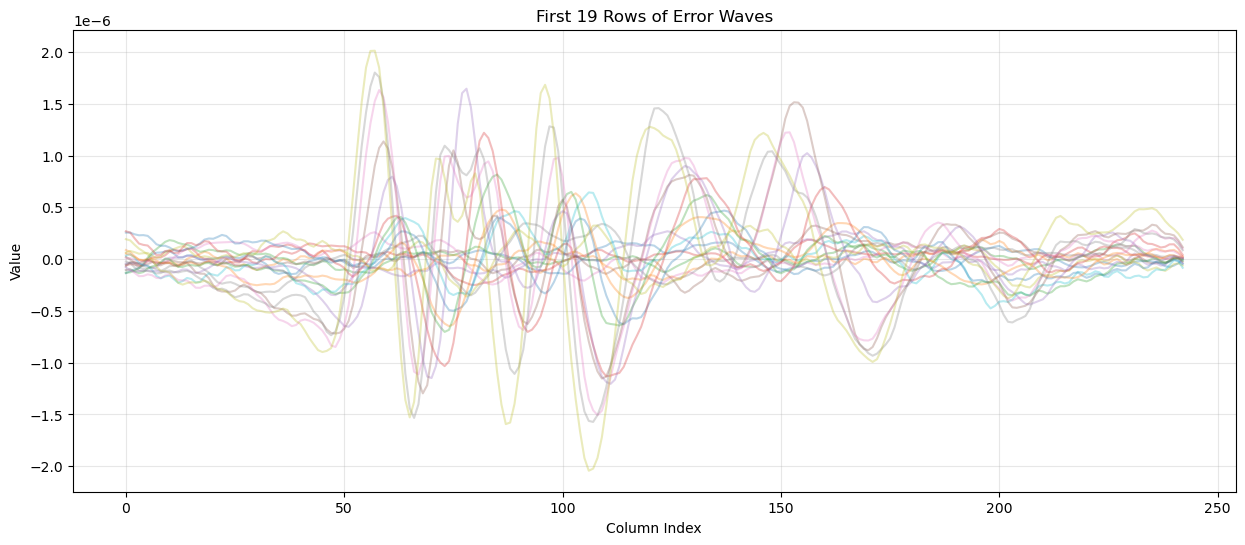

          id_freq   id  timepoint   ear  frequency  manual threshold
121642  109800001  109          1  left     8000.0              40.0


In [96]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Counter for number of rows plotted
rows_plotted = 0
ids = []



# Loop over rows
for i, (_, row) in enumerate(data.iterrows()):  # Iterate over all rows of the DataFrame
    # Check if the value in the `id_freq` column is in `first_column[0:10]`
    if row['id_freq'] in [first_column[1]]: # and row['level'] in [40, 45]:
        ids.append(row['id_freq'])
        plt.plot(row.iloc[2:245].values, alpha=0.3)  # Slice the columns from index 2 to 246 and plot
        rows_plotted += 1



    # Stop after plotting 20 rows
    # if rows_plotted >= 20:
    #     break

# Add labels and title
plt.title(f"First {rows_plotted} Rows of Error Waves")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

print(merged_df[merged_df['id_freq'].isin(ids)][['id_freq','id', 'timepoint', 'ear', 'frequency', 'manual threshold']].drop_duplicates())



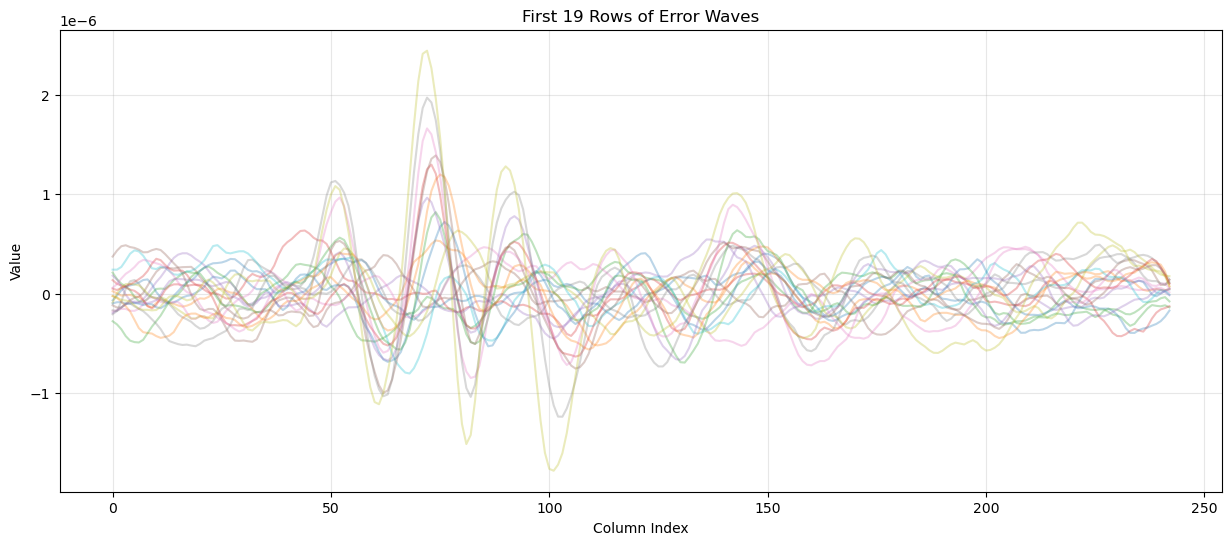

          id_freq   id  timepoint    ear  frequency  manual threshold
57270  1141600011  114          1  right    16000.0              20.0


In [153]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Counter for number of rows plotted
rows_plotted = 0
ids = []



# Loop over rows
for i, (_, row) in enumerate(data.iterrows()):  # Iterate over all rows of the DataFrame
    # Check if the value in the `id_freq` column is in `first_column[0:10]`
    if row['id_freq'] in [first_column[7]]: # and row['level'] in [40, 45]:
        ids.append(row['id_freq'])
        plt.plot(row.iloc[2:245].values, alpha=0.3)  # Slice the columns from index 2 to 246 and plot
        rows_plotted += 1



    # Stop after plotting 20 rows
    # if rows_plotted >= 20:
    #     break

# Add labels and title
plt.title(f"First {rows_plotted} Rows of Error Waves")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

print(merged_df[merged_df['id_freq'].isin(ids)][['id_freq','id', 'timepoint', 'ear', 'frequency', 'manual threshold']].drop_duplicates())



In [ ]:
# Check out functional clustering

In [ ]:
normalized_merged_df.head(5)

,id,manual threshold,level,1,2,3,4,5,6,7,...,236,237,238,239,240,241,242,243,id_freq,Hearing
0,0,40.0,15.0,0.600951,0.524525,0.468409,0.412414,0.342675,0.255969,0.193010,...,0.020515,-0.011562,-0.045580,-0.071435,-0.078972,-0.081087,-0.054537,0.023515,01600000,0
1,0,40.0,20.0,-0.622469,-0.489024,-0.416342,-0.407255,-0.404202,-0.388576,-0.395910,...,0.179337,0.108626,0.031035,-0.042411,-0.092526,-0.081257,-0.010586,0.083955,01600000,0
2,0,40.0,25.0,0.739883,0.770380,0.758815,0.696910,0.569778,0.394513,0.201721,...,0.086412,0.102626,0.123194,0.136408,0.123401,0.082134,0.041566,0.024323,01600000,0
3,0,40.0,30.0,-0.422527,-0.495352,-0.587536,-0.719317,-0.837653,-0.890947,-0.922574,...,-0.364862,-0.345238,-0.329188,-0.329386,-0.299165,-0.235088,-0.189407,-0.156326,01600000,0
4,0,40.0,35.0,-0.229618,-0.220355,-0.231026,-0.223591,-0.202366,-0.167653,-0.113815,...,-0.468449,-0.533057,-0.539197,-0.523349,-0.474118,-0.374838,-0.256068,-0.143360,01600000,0


In [138]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def process_deafness_method_1(df, model):
    # Get top 3 levels per id_freq
    top_3 = df.sort_values(["id_freq", "level"], ascending=[True, False]).groupby("id_freq").head(3)

    # Prepare features for prediction
    X_test = np.array([interpolate_and_smooth(x_row) for x_row in top_3.iloc[:, 3:246].values])
    
    # Predict all at once
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    # Add predictions back to DataFrame
    top_3["y_pred"] = y_pred

    # Regroup and calculate deafness conditions
    grouped = top_3.groupby("id_freq").agg(
        deaf=("y_pred", lambda x: int(np.all(x == 0))),  # All 0 → Deaf
        manual_inf=("manual threshold", lambda x: np.any(x == np.inf)),  # Any np.inf
        manual_thresholds = ("manual threshold", max)
    ).reset_index()

    return grouped

def process_deafness_method_2(df, model):
    # Get top 3 levels per id_freq
    top_3 = df.sort_values(["id_freq", "level"], ascending=[True, False]).groupby("id_freq").head(3)

    # Prepare features for prediction
    X_test = np.array([interpolate_and_smooth(x_row) for x_row in top_3.iloc[:, 3:246].values])

    # Predict all at once
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Add predictions back to DataFrame
    top_3["y_pred"] = y_pred

    # Regroup and compute required values
    grouped = top_3.groupby("id_freq").agg(
        count_zeros=("y_pred", lambda x: np.sum(x == 0)),
        max_level=("level", "max"),
        manual_threshold=("manual threshold", "max")
    ).reset_index()

    grouped["condition_met"] = (grouped["count_zeros"] == 2) & (grouped["max_level"] == grouped["manual_threshold"])

    return grouped

def analyze_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values related to deaf mice
    deaf_mice = np.sum(y_true == 1)  # Total actual deaf mice
    successfully_labeled_deaf = np.sum((y_true == 1) & (y_pred == 1))  # Correctly labeled deaf mice

    return cm, {"total_deaf_mice": deaf_mice, "successfully_labeled_deaf": successfully_labeled_deaf}


In [154]:
# No of unique id_freqs in normalized_merged_df
len(test_df['id_freq'].unique())

1753

In [140]:
deaf_df = process_deafness_method_1(normalized_merged_df, model)

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/1g/bksky7bd2wb927qzgc2fqjhc0000gn/T/ipykernel_2840/165097093.py:19: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped = top_3.groupby("id_freq").agg(


In [141]:
deaf_df.shape

(7894, 4)

In [142]:
deaf_df.head(5)

,id_freq,deaf,manual_inf,manual_thresholds
0,01600000,0,False,40.0
1,03200000,0,False,45.0
2,0800000,0,False,45.0
3,1001131300,0,False,30.0
4,1001131310,1,True,inf


In [143]:
cm, deaf_stats = analyze_confusion_matrix(deaf_df["manual_inf"], deaf_df["deaf"])
print(cm)
print(deaf_stats)

[[6983  137]
 [ 103  671]]
{'total_deaf_mice': 774, 'successfully_labeled_deaf': 671}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

In [156]:
671/774

0.8669250645994832

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

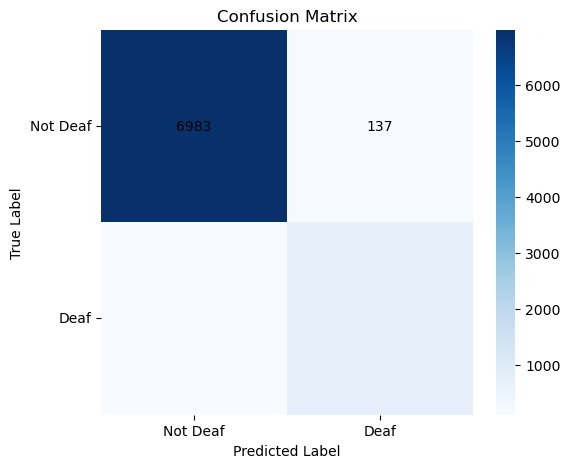

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm, deaf_stats = analyze_confusion_matrix(deaf_df["manual_inf"], deaf_df["deaf"])
    
    if labels is None:
        labels = ["Not Deaf", "Deaf"]
    
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        annot_kws={'color': 'black'}  # Set annotation text color to black
    )
    
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")

    plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
    plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0)
    
    plt.show()

# Usage
plot_confusion_matrix((deaf_df["manual_inf"] == True).astype(int), deaf_df["deaf"].astype(int))


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categoric

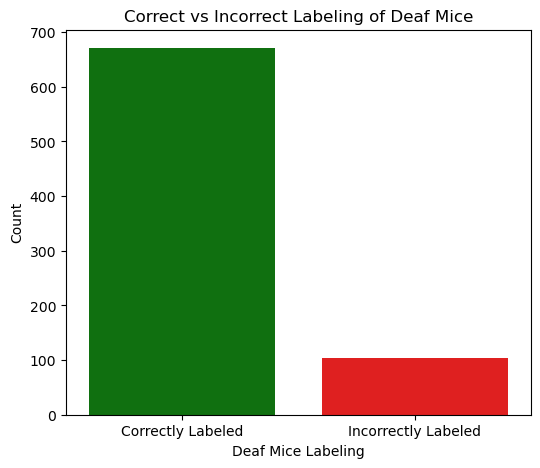

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract values from confusion matrix
total_deaf_mice = deaf_stats["total_deaf_mice"]  # All actual deaf mice
correctly_labeled_deaf = deaf_stats["successfully_labeled_deaf"]  # True Positives (TP)
incorrectly_labeled_deaf = total_deaf_mice - correctly_labeled_deaf  # False Negatives (FN)

# Create bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=["Correctly Labeled", "Incorrectly Labeled"], y=[correctly_labeled_deaf, incorrectly_labeled_deaf], palette=["green", "red"])

# Labels and title
plt.xlabel("Deaf Mice Labeling")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Labeling of Deaf Mice")

# Show plot
plt.show()


In [149]:
import matplotlib.pyplot as plt

def plot_manual_threshold_for_misclassified_deaf(df, y_true, y_pred):
    # Create confusion matrix
    cm, stats = analyze_confusion_matrix(y_true, y_pred)
    
    # Generate a mask for "labeled deaf but not actually deaf"
    misclassified_deaf_mask = (y_pred == 1) & (y_true == 0)
    
    # Apply mask to the DataFrame
    misclassified_deaf_df = df[misclassified_deaf_mask]
    
    # Plot the distribution of manual threshold for these misclassified deaf entries
    plt.figure(figsize=(10, 6))
    plt.hist(misclassified_deaf_df["manual_thresholds"].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Manual Threshold for Labeled Deaf but Not Actually Deaf")
    plt.xlabel("Manual Threshold")
    plt.ylabel("Frequency")
    plt.show()
    
    return misclassified_deaf_df


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

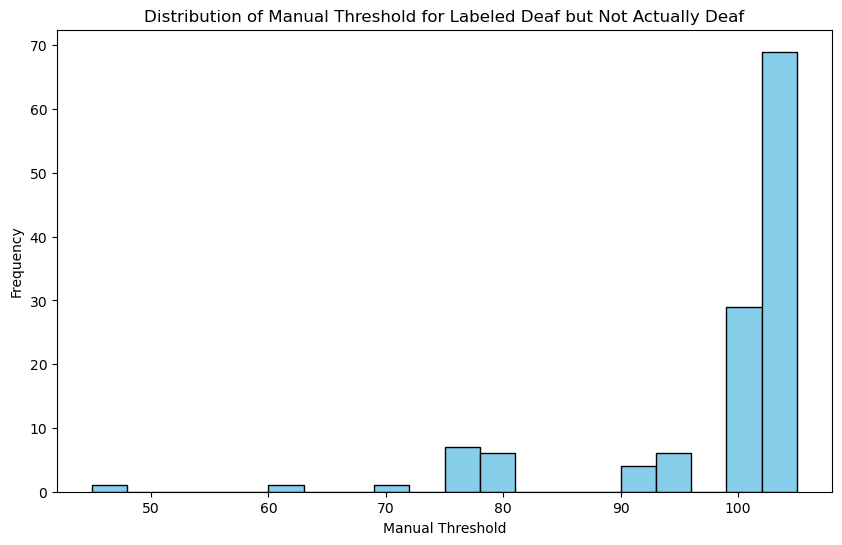

,id_freq,deaf,manual_inf,manual_thresholds
113,10400000,1,False,100.0
188,106800010,1,False,105.0
260,11131300,1,False,75.0
458,115400000,1,False,100.0
472,115565613,1,False,105.0
...,...,...,...,...
7289,7565600,1,False,75.0
7422,823200013,1,False,105.0
7442,82565613,1,False,105.0
7563,873200010,1,False,100.0


In [150]:
plot_manual_threshold_for_misclassified_deaf(deaf_df, (deaf_df["manual_inf"] == True).astype(int), deaf_df["deaf"].astype(int))

In [129]:
deaf_df_2 = process_deafness_method_2(normalized_merged_df, model)

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [130]:
deaf_df_2.head(5)

,id_freq,count_zeros,max_level,manual_threshold,condition_met
0,01600000,0,80.0,40.0,False
1,03200000,0,80.0,45.0,False
2,0800000,0,80.0,45.0,False
3,1001131300,0,105.0,30.0,False
4,1001131310,3,105.0,inf,False


In [134]:
cm2, deaf_stats_2 = analyze_confusion_matrix(
    (deaf_df_2["count_zeros"] >= 2).astype(int),  # Convert Boolean to int (True -> 1, False -> 0)
    deaf_df_2["manual_threshold"].isin([np.inf, *deaf_df_2["max_level"]]).astype(int)  # Check condition properly
)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_arr

In [135]:
print(cm2)
print(deaf_stats_2)

[[5552 1113]
 [  87 1142]]
{'total_deaf_mice': 1229, 'successfully_labeled_deaf': 1142}
